In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/Library/Python/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load, clean, dress data

In [3]:
df1 = pd.read_csv('../data/Fake.csv')
df2 = pd.read_csv('../data/True.csv')
df1['is_real'] = 0
df2['is_real'] = 1
df = df1.append(df2)

In [4]:
df.head()

,title,text,subject,date,is_real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
df = df[df['date']!= 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/']
df = df[df['date']!= 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/']
df = df[df['date']!= 'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/']
df = df[df['date']!= 'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg']
df = df[df['date']!= 'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg']
df = df[df['date']!= 'MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]']

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday

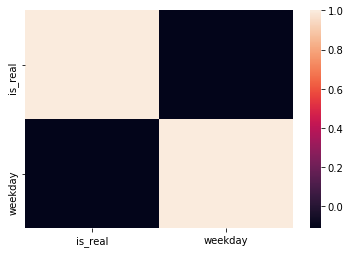

In [7]:
sns.heatmap(df.corr())

I tried to engineer what day of the week an article was published but it seems as if it doesn't correlate.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 21416
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    44888 non-null  object        
 1   text     44888 non-null  object        
 2   subject  44888 non-null  object        
 3   date     44888 non-null  datetime64[ns]
 4   is_real  44888 non-null  int64         
 5   weekday  44888 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.4+ MB


# EDA

most_freq() returns the most common words from the text of all fake and real articles.

In [31]:
def most_freq(df):
    cvec = CountVectorizer(stop_words = 'english')

    cvec.fit(df['text'])

    X_train = cvec.transform(df['text'])
  
    X_train_df = pd.DataFrame(X_train.toarray(),
                              columns=cvec.get_feature_names())
    top_words = {}
    for i in X_train_df.columns:
        top_words[i] =  X_train_df[i].sum()
    return pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True)).head(25)

In [32]:
common_fake = most_freq(df1)

In [33]:
common_true = most_freq(df2)

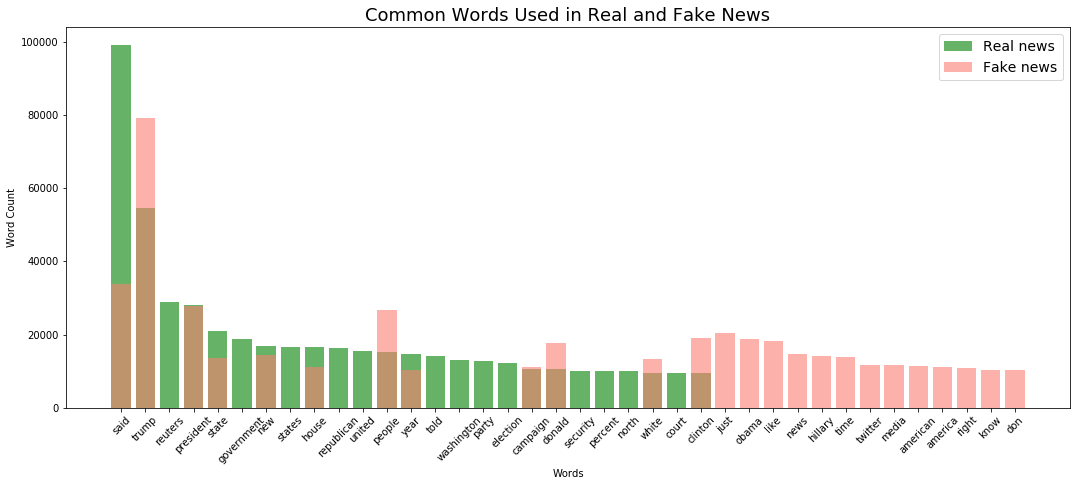

In [34]:
# code inspired by 4.05 classification metrics
plt.figure(figsize = (18, 7))
plt.bar(x = common_true[0],
        height = common_true[1],
        color = 'g',
        alpha = 0.6,
        label = 'Real news')
plt.bar(x = common_fake[0],
        height = common_fake[1],
        color = 'salmon',
        alpha = 0.6,
        label = 'Fake news')
plt.xticks(rotation=45)
plt.ylabel('Word Count')
plt.xlabel('Words')
plt.title('Common Words Used in Real and Fake News', fontsize=18)
plt.legend(fontsize=14);

# Modeling

In [13]:

X = df['text']
y = df['is_real']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
X_train.shape

(33666,)

In [15]:
y_train.shape

(33666,)

In [16]:
pipe_logreg = Pipeline(steps = [('vectorizer', TfidfVectorizer()),    
                         ('model', LogisticRegression(solver="liblinear"))        
                        ])    

hyperparams = {'vectorizer__ngram_range': [(1,2)],
               'vectorizer__stop_words': ['english'],    
               'model__penalty': [ 'l2'],
               'model__C': [ 10],
               'model__max_iter' : [ 1000]
              }

gs = GridSearchCV(pipe_logreg, 
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [17]:
pipe_rf = Pipeline(steps = [('vectorizer', TfidfVectorizer()),    
                         ('model', RandomForestClassifier())        
                        ])    

hyperparams = {#'vectorizer__ngram_range': [(1,1), (2,2), (1,2)],
               'vectorizer__stop_words': ['english'],    
               'model__n_estimators': [150],
               'model__max_depth': [None]
              }

rf_gs = GridSearchCV(pipe_rf, 
                 param_grid=hyperparams,
                 cv = 5)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [18]:
pipe_et = Pipeline(steps = [('vectorizer', TfidfVectorizer()),    
                         ('model', ExtraTreesClassifier())        
                        ])    

hyperparams = {'vectorizer__ngram_range': [(1,1)],
               'vectorizer__stop_words': ['english'],    
               'model__n_estimators': [ 200],
               'model__max_depth': [None]
              }

et_gs = GridSearchCV(pipe_et, 
                 param_grid=hyperparams,
                 cv = 5)
et_gs.fit(X_train, y_train)

et_gs.best_params_

{'model__max_depth': None,
 'model__n_estimators': 200,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

# Model Evaluation

Handy little function to return specificity and sensitivity.

In [ ]:


def sens_spef_quik(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    sens = tp/(tp+fn)
    spef = tn/(tn+fp)
    print(f'The sensitivity is: {sens}')
    print(f'The specificity is: {spef}')

{'0': {'precision': 0.9951923076923077,
  'recall': 0.9877300613496932,
  'f1-score': 0.9914471433458776,
  'support': 5868},
 '1': {'precision': 0.9866617265653946,
  'recall': 0.9947702652222637,
  'f1-score': 0.9906994047619048,
  'support': 5354},
 'accuracy': 0.991088932454108,
 'macro avg': {'precision': 0.9909270171288511,
  'recall': 0.9912501632859785,
  'f1-score': 0.9910732740538912,
  'support': 11222},
 'weighted avg': {'precision': 0.9911223797513442,
  'recall': 0.991088932454108,
  'f1-score': 0.9910903983468943,
  'support': 11222}}

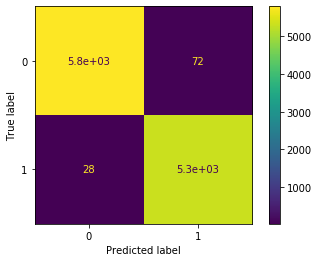

In [20]:
log_pred = gs.predict(X_test)
plot_confusion_matrix(gs,X_test,y_test);
classification_report(y_test,log_pred, output_dict=True)

{'0': {'precision': 0.992798353909465,
  'recall': 0.9867075664621677,
  'f1-score': 0.9897435897435898,
  'support': 5868},
 '1': {'precision': 0.9855287569573283,
  'recall': 0.9921553978333956,
  'f1-score': 0.988830975428146,
  'support': 5354},
 'accuracy': 0.9893067189449296,
 'macro avg': {'precision': 0.9891635554333966,
  'recall': 0.9894314821477816,
  'f1-score': 0.9892872825858678,
  'support': 11222},
 'weighted avg': {'precision': 0.9893300396979394,
  'recall': 0.9893067189449296,
  'f1-score': 0.9893081827711352,
  'support': 11222}}

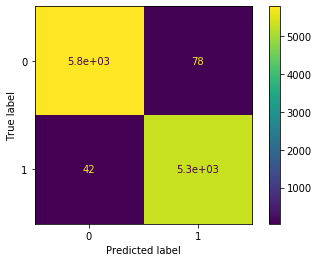

In [21]:
rf_pred = rf_gs.predict(X_test)
plot_confusion_matrix(rf_gs,X_test,y_test);
classification_report(y_test,rf_pred, output_dict=True)

{'0': {'precision': 0.9913359902963091,
  'recall': 0.9749488752556237,
  'f1-score': 0.9830741472635106,
  'support': 5868},
 '1': {'precision': 0.973032471106219,
  'recall': 0.9906611878968995,
  'f1-score': 0.9817677001388248,
  'support': 5354},
 'accuracy': 0.9824451969345928,
 'macro avg': {'precision': 0.982184230701264,
  'recall': 0.9828050315762615,
  'f1-score': 0.9824209237011676,
  'support': 11222},
 'weighted avg': {'precision': 0.9826034077135483,
  'recall': 0.9824451969345928,
  'f1-score': 0.9824508432263009,
  'support': 11222}}

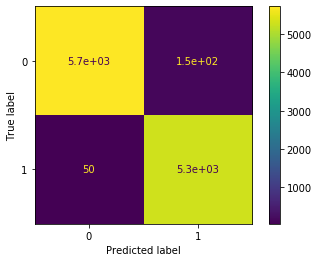

In [22]:
et_pred= et_gs.predict(X_test)
plot_confusion_matrix(et_gs,X_test,y_test);
classification_report(y_test,et_pred, output_dict=True)

# Results

In [23]:
print(f'Best LR TRAIN set accuracy: {gs.best_score_}')
print(f'Best LR TEST set accuracy: {gs.score(X_test, y_test)}')
sens_spef_quik(y_test,log_pred )
print(f'Best RF TRAIN set accuracy: {rf_gs.best_score_}')
print(f'Best RF TEST set accuracy: {rf_gs.score(X_test, y_test)}')
sens_spef_quik(y_test,rf_pred )
print(f'Best ET TRAIN set accuracy: {et_gs.best_score_}')
print(f'Best ET TEST set accuracy: {et_gs.score(X_test, y_test)}')
sens_spef_quik(y_test,et_pred )

Best LR TRAIN set accuracy: 0.9886235370997446
Best LR TEST set accuracy: 0.991088932454108
The sensitivity is: 0.9947702652222637
The specificity is: 0.9877300613496932
Best RF TRAIN set accuracy: 0.9894552322890359
Best RF TEST set accuracy: 0.9893067189449296
The sensitivity is: 0.9921553978333956
The specificity is: 0.9867075664621677
Best ET TRAIN set accuracy: 0.9810491313833065
Best ET TEST set accuracy: 0.9824451969345928
The sensitivity is: 0.9906611878968995
The specificity is: 0.9749488752556237


| Estimators/Classifiers | Model 1 | Model 2 | Model 3 | Model 4 | Model 5 | Model 6 | Model 7 | Model 8
|-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| `PorterStemmer()` | X |  |  | X | X | | | |
| `CountVectorizer()` | X | X |  |  |  | | | |
| `TfidfVectorizer()` |  |  | X | X | X | X | X | X |
| `LogisticRegression()` | X | X | X | X |  | X | | |
| `RandomForestClassifier()` |  |  |  |  | X | | X | |
| `ExtraTreesClassifier()` | | | | | | | | X|
| `Title as Feature` | X | X | X | X | X | | | |
| `Text as Feature`| | | | | | X | X | X |
| Train Score: | 0.9849 | 0.9840 | 0.9505 | 0.9563 | 0.9504 | 0.9886 | 0.9895 | 0.9819|
| Test Score: | **0.9660** | 0.9529 | 0.9588 | 0.9643 | 0.9623 | 0.9910 | 0.9893 | 0.9824 |
**Hyperparameters used in best score:**
| Estimator/Transformer | Hyperparameter | Set to: |
|-|-|-|
| `TfidVectorizer()` | `stop_words` | `english` |
| `LogisticRegression()` | `max_iter` | 1000 |
| `LogisticRegression()` | `solver` | `liblinear` |